<a href="https://colab.research.google.com/github/AkiraNom/data-analysis-notebook/blob/main/Bayesian_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import pymc as pm
import arviz as az

Situation:
  You want to test new recommendation algorithms for selecting next songs. To run bayesian inference, we will use data: <br>

  * If a user skipped a song or not
  

Synthetic data generation

1. data for skipping a song or not is generated by the binomial distribution

In [168]:
# sample size
n = 300

group_list = ['A', 'B']

# true skip rate
p_list = [0.56, 0.50]

# control (A): current playlist
# new_algorithm (B): quicker to skip, more skips

full_df = pd.DataFrame()

for g in range(len(group_list)):

    curr_group = group_list[g]
    curr_p = p_list[g]

    skipped = np.random.binomial(size = n, n = 1, p = curr_p)

    df = pd.DataFrame(skipped, columns = ['skipped'])

    df['skipped'] = skipped

    df['group'] = curr_group

    full_df = pd.concat([full_df, df])

full_df = full_df.reset_index(drop=True).reset_index().rename(columns = {'index':'user_id'})

In [169]:
full_df.head()

,user_id,skipped,group
0,0,1,A
1,1,1,A
2,2,0,A
3,3,0,A
4,4,1,A


In [170]:
observed=full_df[full_df['group'] == 'A']['skipped']

In [171]:
full_df['group'].value_counts()

A    300
B    300
Name: group, dtype: int64

In [172]:
# ratio of user skipped a song
skipped_counts = full_df[full_df['skipped']==1]['skipped'].value_counts().values[0]
no_skipped_counts = full_df[full_df['skipped']==0]['skipped'].value_counts().values[0]

ratio_skipped = skipped_counts / len(full_df)

print(f'Proportion of users who skipped a song is {ratio_skipped*100:.2f}%.')

Proportion of users who skipped a song is 53.50%.


In [173]:
skip_df = full_df.dropna()

In [174]:
data_A = full_df[full_df['group'] == 'A']['skipped']
data_B = full_df[full_df['group'] == 'B']['skipped']

In [175]:
prior_alpha = [5, 5]
prior_beta = [100, 100]

with pm.Model() as model:

    # skip rate
    p_A = pm.Beta('A_skip_rate', prior_alpha[0], prior_beta[0])
    p_B = pm.Beta('B_skip_rate', prior_alpha[1], prior_beta[1])

    # likelihood
    A_obs = pm.Bernoulli('A_observations', p_A, observed=data_A)
    B_obs = pm.Bernoulli('B_observations', p_B, observed=data_B)

    # define metrics
    pm.Deterministic('difference', p_B - p_A)



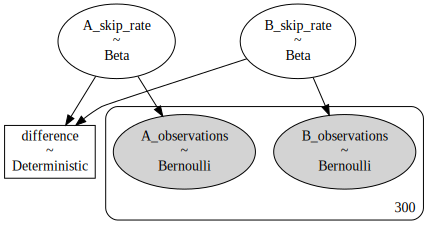

In [176]:
pm.model_to_graphviz(model)

In [177]:
with model:
  idata = pm.sample(draws=25000, tune=1500)

array([[<Axes: title={'center': 'A_skip_rate'}>,
        <Axes: title={'center': 'A_skip_rate'}>],
       [<Axes: title={'center': 'B_skip_rate'}>,
        <Axes: title={'center': 'B_skip_rate'}>],
       [<Axes: title={'center': 'difference'}>,
        <Axes: title={'center': 'difference'}>]], dtype=object)

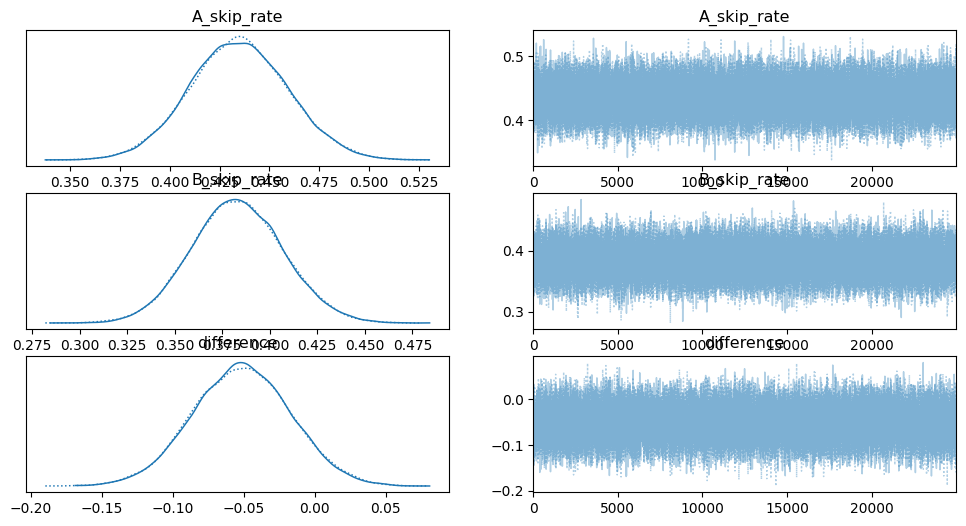

In [178]:
az.plot_trace(idata, compact =True)

array([<Axes: title={'center': 'A_skip_rate'}>,
       <Axes: title={'center': 'B_skip_rate'}>,
       <Axes: title={'center': 'difference'}>], dtype=object)

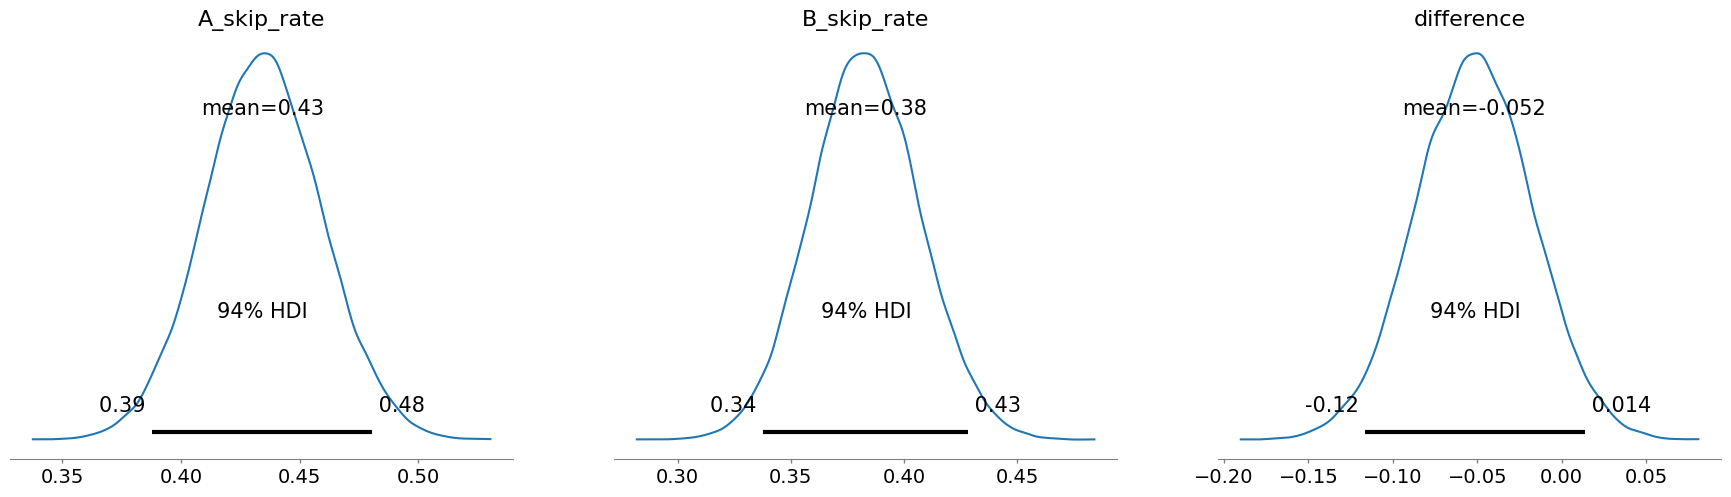

In [179]:
az.plot_posterior(idata)

In [180]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Text(0.5, 1.0, 'Posterior Distributions of Skip Rate\nfor Each Test Group')

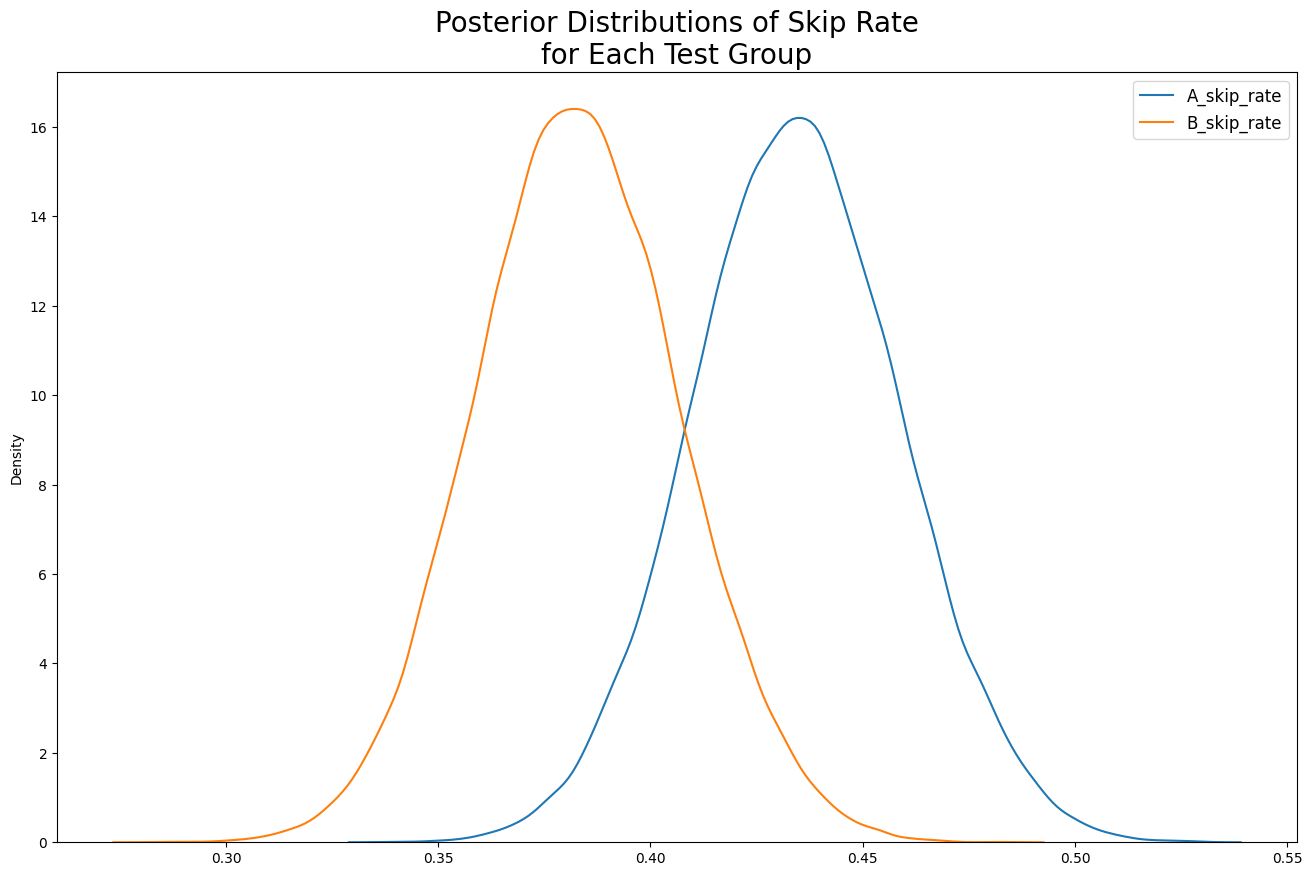

In [181]:

plt.figure(figsize=(16,10))

posteriors = []
posterior_vars = ['A_skip_rate', 'B_skip_rate']

for p in posterior_vars:
    posteriors.append(idata.posterior.stack(sample=['chain','draw'])[p])

for posterior in posteriors:
    sns.kdeplot(posterior, legend = True)

plt.legend(loc='upper right', labels = posterior_vars, fontsize=12)
plt.title('Posterior Distributions of Skip Rate\nfor Each Test Group', fontsize=20)

In [182]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [183]:
samples_A = idata.posterior['A_skip_rate'].values
samples_B = idata.posterior['B_skip_rate'].values

print(f'Probability of users who skip a song in B algorithm is : {(samples_B < samples_A).mean():.1%}.')


Probability of users who skip a song in B algorithm is : 93.3%.


Based on the posterior distribution, the skip rate with the B algorithm is between 0.34 and 0.43 with probability of 94%. The algorithm B is more likely better recommendation algorithm with a lower skip rate than the current algorithm A.  